
# **Random Music Generator**
---
CSCI 1470 Final Project \\

Authors: Zhuoyang Lyu, Yixiang Sun, Zixuan Guo \\
Instructor: Vadim Kudlay \\
Date: November 20, 2022 




---

\\
We are a group of music lovers and musicians, and naturally we thought about making music with what we learned about deep learning this semester. We realized a strong resemblance between language generation and music generation, replacing individual words with musical notes and we decided to create a model that can learn from given music data and generate more music. This will be a structured prediction problem similar to classic NLP topics.



# Data and Preprocess

- We found a publicly available dataset on kaggle: MusicNet, a curated collection of labeled classical music. \\

- “MusicNet is a collection of 330 freely-licensed classical music recordings, together with over 1 million annotated labels indicating the precise time of each note in every recording, the instrument that plays each note, and the note's position in the metrical structure of the composition. The labels are acquired from musical scores aligned to recordings by dynamic time warping. The labels are verified by trained musicians; a labeling error rate of 4% has been estimated. The MusicNet labels are offered to the machine learning and music communities as a resource for training models and a common benchmark for comparing results.” \\

- We plan to only use the annotated note as our data, not the raw audio files. We will need to embed the notes to an embedding space not only of its pitch but its length and possibly its instrument.

Link: https://www.kaggle.com/datasets/imsparsh/musicnet-dataset




---



In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
from statistics import mode

In [ ]:
import os
import sys

isColab = "google.colab" in sys.modules
# this also works: 
# isColab = "COLAB_GPU" in os.environ

if isColab:
    from google.colab import drive 
    drive.mount("/content/drive", force_remount=True) 

    colab_path = ("/content/drive/MyDrive/final")

Mounted at /content/drive


We first implement a prepare_data method to load our music dataset.

In [ ]:
def prepare_data(meta_filename, filepath, \
    use_composer = True, use_composition = True, use_movement = True, use_ensemble = True):
    """
    main method to prepare data.
    params:
    meta_filename is the file name of the meta files
    filepath is the path of the folder that contains all the data
    use_* indicates whether to use those meta features as the data feature 
    """
    def load_music_data(filepath):
        all_filenames = glob.glob(filepath + "/*.csv")
        music_data = []
        for filename in all_filenames:
            temp = pd.read_csv(filename)
            temp['id'] = os.path.basename(filename[:-4])
            music_data.append(temp)
        music_data = pd.concat(music_data, axis=0, ignore_index=True)
        music_data['id'] = music_data['id'].astype(str).astype(int)

        return music_data
        
    #load meta-data
    meta_data = pd.read_csv(meta_filename)

    #load music
    music_data = load_music_data(filepath)

    #merge two data
    all_data = meta_data.merge(music_data, on = 'id')
    all_data = all_data.drop(['source', 'transcriber', 'catalog_name'], axis=1)

    return all_data

Now we load the metadata and test labels to test the functionality of our prepare_data function. \\
We can see that there are many features included in the dataset, and not all of them are useful for our procedures later. Therefore, we need to perform some **feature engineering**. \\
One important feature we want to focus on is the **key** of each piece of music, which is not directly given by our dataset. \\

***What is a music key and why is it important? ***

- In music a key is the major or minor scale around which a piece of music revolves. A song in a major key is based on a major scale. A song in a minor key is based on a minor scale.

- The root note of the key acts as the center of the key. Similar to the root notes of chords, the root note of a scale is the note on which a scale is built. For example, the root of the C major scale is C.

- When you play music, the music is constantly being pulled toward the tonic, or root of the key, wanting to come to a state of rest or completion. The tonic is the most resolved note in a key. The tonic is a key’s center.

- When music has this centered sound to it, it is said to be tonal (pronounced TOE-nul), or possessing tonality. Almost all music to which we listen is tonal. When a piece of music lacks a tonal center it is said to be atonal (pronounced AY-toe-nul). Most people don't like the sound of atonal music.

from(https://www.studybass.com/lessons/harmony/keys-in-music/)

This generally explains why we want to know the key of each piece of music, since we aim for producing music that is acceptable for most people. 



---


The following gives an overview of our dataset.

In [ ]:
data = prepare_data('/content/drive/MyDrive/final/archive/musicnet_metadata.csv',
                    '/content/drive/MyDrive/final/archive/musicnet/musicnet/test_labels')

data.head()


,id,composer,composition,movement,ensemble,seconds,start_time,end_time,instrument,note,start_beat,end_beat,note_value
0,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,63,0.0,1.000,Quarter
1,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,75,0.0,1.000,Quarter
2,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,110558,1,48,0.0,0.375,Dotted Sixteenth
3,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,114654,122334,1,55,0.5,0.375,Dotted Sixteenth
4,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,124382,139742,1,65,1.0,1.000,Quarter


In [ ]:
categories = np.array(data.keys())
print('The following features are in the dataset:')
print(categories)

The following features are in the dataset:
['id' 'composer' 'composition' 'movement' 'ensemble' 'seconds'
 'start_time' 'end_time' 'instrument' 'note' 'start_beat' 'end_beat'
 'note_value']


First, we experiment with the "composition" feature in our dataset. By observing the compositions, we find that the key of the music is often included in them. For example, "Piano Sonata No 30 in E major", in which 'E' defines the key of the music. \\
In many cases, the key is located at the second from last element of the array. Therefore, we perform splitting on the second from last element to check if this method could work. 

In [ ]:
composition = np.unique(data['composition'].to_numpy())
print(f'There are {len(composition)} compositions included:')
print(composition)

There are 10 compositions included:
['Cello Suite 4' 'Piano Sonata No 30 in E major' 'Piano Sonata in C minor'
 'Quartet No 53 in D major' 'Serenade in E-flat major'
 'Sextet in E-flat major for Winds' 'String Quartet No 13 in B-flat major'
 'Violin Partita No 3 in E major' 'Violin Sonata No 10 in G major'
 'WTK I, No. 5: Prelude and Fugue in D major']


In [ ]:
print(set([c.split()[-2] for c in composition]))

{'C', 'D', 'G', 'for', 'E', 'Suite', 'E-flat', 'B-flat'}


As we can see, some irrelevant elements is included. So it is better to find another way to determine the key. \\

Since our input data consists of notes with labeled features, our goal is to determine the key of each note with respect to its composition. \\

Therefore, we can implement a method find_keys(). If the second from last element of the composition is a key, we set it as the key of the note; otherwise, we will assume the most common note in the piece to be the key, and set it as the key of the note. \\

We process our data with this method to get an array of keys of each input note. 

In [ ]:
def find_keys(all_data):
        """
        find the key each note is in. If the composition specifies the key, use 
        it, otherwise we assume the most common note in the peice to be the key.

        params: data frome of the complete data

        return: array of keys of each input note
        """
        ref = {'C':0, 'C-sharp':1, 'D-flat':1, 'D':2, 'D-sharp':3, 'E-flat':3, 'E':4, \
            'F':5, 'F-sharp':6, 'G-flat':6, 'G':7, 'G-sharp':8, 'A-flat':8, 'A':9, 
            'A-sharp':10, 'B-flat':10, 'B':11}

        data = np.array(all_data['composition'])
        unresolved = []

        for i, d in enumerate(data):
            if d.split()[-2] in ref:
                data[i] = ref[d.split()[-2]]
            else:
                if d not in unresolved:
                    unresolved.append(d)
        
        unresolved_dict = {}
        for composition in unresolved:
            notes_in_piece = all_data[all_data['composition'] == composition]['note']
            notes_in_piece = np.array(notes_in_piece) % 12
            #we assume the key is the most common note in the piece
            unresolved_dict[composition] = mode(notes_in_piece)
        for i, d in enumerate(data):
            if d in unresolved_dict:
                data[i] = unresolved_dict[d]
        
        return np.array(data)

Now, we have the knowledge of the key of each music piece, but there is still a step left before we can introduce it to the data yet. We need to the note degree, or a note's scale degree. \\

**Why is note degree important?**

- A scale is a collection of pitches that follows a set pattern of ascending or descending intervals. A major scale, for example, may start on any note, as long as the subsequent notes follow the appropriate pattern of whole steps and half steps. The same is true of minor scales—but with a different pattern of steps, of course.

- Since there are so many major and minor scales, all with differing pitches, it can be useful to refer to the steps of the scale by numbers rather than notes. These numbers are called “scale degrees” and are assigned in ascending order, beginning with the lowest pitch as 1. You may also hear scale degrees referred to by more technical names, as shown below. (Scale degree 7 has two names, depending on whether you are in major or minor.)

- A note’s scale degree gives you an idea of how the note will function in a piece of music written in the scale’s key. Music is all about creation and release of tension—so the function of a scale degree has to do with the amount of tension it creates and where it “wants” to move next in order to resolve the tension. The most important functions to understand are those of scale degree 1 (tonic), scale degree 5 (dominant) and scale degree 7 (leading tone or subtonic, depending on whether you are in major or minor, respectively).

(from https://makingmusicmag.com/a-guide-to-scale-degrees/) \\


---
\\
This is the reason for us to include the method calculate_degree(), which takes in an array of notes and an array of keys of the same length (where the notes come from), and convert them to an array of note degree. \\

The presensce of note degree enables us to better interpret the general "flow" of the music, which gives us more information on finding the appropriate next note given an existing music piece with a known key. 

In [ ]:

def calculate_degree(notes, keys):
        """
        calculate the tonal degree of each term

        params: a 1-d array of notes and a 1-d of keys of the piece where the note
        came from. They should have the same length

        return: array of note degree
        """
        re = []
        for (n, k) in zip(notes, keys):
            diff = n % 12 - k
            diff = diff + 12 if diff < 0 else diff
            re.append(diff)
        return np.array(re)

In [ ]:

data['note_degree'] = calculate_degree(data['note'].to_numpy(), find_keys(data))
data.head()

,id,composer,composition,movement,ensemble,seconds,start_time,end_time,instrument,note,start_beat,end_beat,note_value,note_degree
0,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,63,0.0,1.000,Quarter,3
1,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,75,0.0,1.000,Quarter,3
2,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,0
3,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,7
4,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,124382,139742,1,65,1.0,1.000,Quarter,5


Now, we have introduced a new feature 'note_degree' to the data, which contains the scale degree of the note in its music composition.

For the convenience of later calculation, we introduce a method modulate(), which can modulate all the notes to the same key (C major). With all the different keys for different music pieces, it sometimes turns easy for the machine to get confused. That's why we make our data more homogenous, which is easier for our model to train. 

In [ ]:
def modulate(notes, keys):
        """
        modulate all the notes to the same key(C major)
        """
        modulated_notes = []
        for i in range(len(notes)):
            modulated_notes.append(notes[i] - keys[i])
        return np.array(modulated_notes)

In [ ]:
data = prepare_data('/content/drive/MyDrive/final/archive/musicnet_metadata.csv',
                    '/content/drive/MyDrive/final/archive/musicnet/musicnet/test_labels')
print('Convert notes from a B-flat composition to C major:')
print('Before modulate:')
print(find_keys(data)[10000:10010])
print(data['note'].to_numpy()[10000:10010])

Convert notes from a B-flat composition to C major:
Before modulate:
[10 10 10 10 10 10 10 10 10 10]
[58 70 75 66 58 69 66 58 75 69]


In [ ]:
print('After modulate:')
data['note'] = modulate(data['note'], find_keys(data))
print(find_keys(data)[10000:10010])
print(data['note'].to_numpy()[10000:10010])

After modulate:
[0 0 0 0 0 0 0 0 0 0]
[48 60 65 56 48 59 56 48 65 59]


Next, we need to one_hot encode the data under some features in our dataset. 

Especially, one_hot encoding is necessary for the features 'note value', 'ensemble', and 'movement'. The way we extract information for the key of the music pieces with the 'composition' feature is not compatible for these since it is hard to identity a general pattern. 

Like in many other cases of machine learning, we don't want machine learning to assume that higher numbers are more important. We cannot simply convert them to numbers. Since these data are categorical, we can apply one_hot encoding.



In [ ]:
def one_hot_encoding(array):
    value_dict = {value : index for index, value in enumerate(np.unique(array))}
    array_trans = [value_dict[value] for value in array]
    ohe = tf.one_hot(array_trans, len(value_dict))
    return list(ohe)

In [ ]:
data['note_degree'] = calculate_degree(data['note'].to_numpy(), find_keys(data))
data['movement_ohe'] = one_hot_encoding(data['movement'])
print(data['movement_ohe'][0])
print(data['movement_ohe'][5000])

tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [ ]:
print(np.unique(data['composer']))

['Bach' 'Beethoven' 'Haydn' 'Mozart' 'Schubert']


In [ ]:
data['note_value_ohe'] = one_hot_encoding(data['note_value'].to_numpy())
print(data['note_value_ohe'][0])
print(data['note_value_ohe'][5000])

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(14,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(14,), dtype=float32)


In [ ]:
print(np.unique(data['ensemble']))

['Accompanied Violin' 'Pairs Clarinet-Horn-Bassoon' 'Solo Cello'
 'Solo Piano' 'Solo Violin' 'String Quartet']


In [ ]:
data['ensemble_ohe'] = one_hot_encoding(data['ensemble'])
print(data['ensemble_ohe'][0])
print(data['ensemble_ohe'][5000])

tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32)


In [ ]:
data.head()

,id,composer,composition,movement,ensemble,seconds,start_time,end_time,instrument,note,start_beat,end_beat,note_value,note_degree,movement_ohe,note_value_ohe,ensemble_ohe
0,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,63,0.0,1.000,Quarter,3,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
1,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,124382,1,75,0.0,1.000,Quarter,3,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
2,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,90078,110558,1,48,0.0,0.375,Dotted Sixteenth,0,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
3,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,114654,122334,1,55,0.5,0.375,Dotted Sixteenth,7,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."
4,1759,Schubert,Piano Sonata in C minor,3. Menuetto and Trio,Solo Piano,194,124382,139742,1,65,1.0,1.000,Quarter,5,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T..."


Now it's almost time for us to load our data into the model. 

In order to pass the pandas data frame to the neural network, we need to encode the data to become an numpy array. The following method encode_nn_ready() completes this job for us.

In [ ]:
"""Don't run this cell! Just for display purpose."""
def encode_nn_ready(self):
        """
        make the pandas data frame a tensor to be passed into the neural network
        """
        X = []
        for index, data in self.data.iterrows():
            cur = []
            cur.append(data['seconds'])
            cur.append(data['start_time'])
            cur.append(data['end_time'])
            cur.append(data['instrument'])
            cur.append(data['note'])
            cur.append(data['start_beat'])
            cur.append(data['end_beat'])
            cur.extend(data['note_value'])
            if self.use_movement:
                cur.extend(data['movement'])
            if self.use_ensemble:
                cur.extend(data['ensemble'])
            if self.use_key:
                cur.append(data['note_degree'])
            X.append(np.array(cur, dtype='float32'))

        return np.array(X, dtype='float32')

Import our method from python file. Make sure it works.

In [ ]:
#final test
import preprocessing
data_class = preprocessing.DataClass('/content/drive/MyDrive/final/archive/musicnet_metadata.csv',
                    '/content/drive/MyDrive/final/archive/musicnet/musicnet/test_labels')
data_class.data.head()

,id,composition,movement,ensemble,seconds,start_time,end_time,instrument,note,start_beat,end_beat,note_value,key,note_degree
0,1759,Piano Sonata in C minor,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",194,90078,124382,1,63,0.0,1.000,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0,3
1,1759,Piano Sonata in C minor,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",194,90078,124382,1,75,0.0,1.000,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0,3
2,1759,Piano Sonata in C minor,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",194,90078,110558,1,48,0.0,0.375,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0,0
3,1759,Piano Sonata in C minor,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",194,114654,122334,1,55,0.5,0.375,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0,7
4,1759,Piano Sonata in C minor,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",194,124382,139742,1,65,1.0,1.000,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0,5


After encoding, we obtain our data as a numpy array of floating points with shape (13589, 43).

In [ ]:
X = data_class.encode_nn_ready()
X.shape

(13589, 38)

In [ ]:
example = X[0]
example

array([1.94000e+02, 9.00780e+04, 1.24382e+05, 1.00000e+00, 6.30000e+01,
       0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
       0.00000e+00, 0.00000e+00, 3.00000e+00], dtype=float32)

In case we want to decode the encoded dataset, we also include the method decode_to_datafrom, which does exactly the reverse thing, decode the data back to dataframe. 

In [ ]:
"""Don't run this cell! Just for display purpose."""
def decode_to_datafrom(data):
        df = []
        for d in data: 
            cur = {}
            ind = 0
            cur['seconds'] = int(d[ind])
            ind += 1
            cur['start_time'] = int(d[ind])
            ind += 1
            cur['end_time'] = int(d[ind])
            ind += 1
            cur['instrument'] = int(d[ind])
            ind += 1
            cur['note'] = int(d[ind])
            ind += 1
            cur['start_beat'] = d[ind]
            ind += 1
            cur['end_beat'] = d[ind]
            ind += 1
            cur['movement'] = self.movement_ref[np.argmax(d[ind:ind + len(self.movement_ref)])]
            ind += len(self.movement_ref)
            cur['ensemble'] = self.ensemble_ref[np.argmax(d[ind:ind + len(self.ensemble_ref)])]
            ind += len(self.ensemble_ref)
            df.append(cur)
        
        return pd.DataFrame.from_records(df)

In [ ]:
decoded = data_class.decode_to_datafrom([example])
decoded

,seconds,start_time,end_time,instrument,note,start_beat,end_beat,movement,ensemble
0,194,90078,124382,1,63,0.0,1.0,3. Scherzo: Allegro - Trio,Accompanied Violin


# Preprocess Midi 



---

\\
Apart from using the labeled notes to train our model, we think of an alternative form of data that can be used for training. We can extract the midi-track of the dataset and train the model with midi data directly. This could be a more straight-forward way to accomplish our goal, and can also serve as a baseline model to make reference to. 

For this part, we will first need to preprocess the midi files that contain all the music data. To do this, install the mido library first. Mido is a library for working with MIDI messages and ports. 

In [ ]:
!pip3 install mido==1.2.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 3.2 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf 
import pandas as pd
import glob
from mido import MidiFile
from mido import MidiTrack
from mido import Message
import os

Let's take a overview of the midi tracks. Notes and other information of the music are all presented in a special format in midi file. We need to know what they mean in order to let our model interpret the music structure easier.

- “note_on” tells the key is to be pressed (or released, if velocity=0).
- “note_off” tells the key is to be released (velocity should always be set to 0).
- “channel” tells to which channel the sound is to be sent. The standard midi supports 16 channels simultaneously.
- “note” tells which key it is. We can refer to the map below for the corresponding key on piano keyboard to each midi note id.
- “velocity” tells how fast to strike the key, the faster it is, the louder the sound is.
- “time” tells us the waiting time between the last and current operation. The duration of a note is the sum of “time” from each message in between of 2 nearest messages about the same note, where the first one tells you to on the note (when you see “note_on”, and “velocity” > 0) and the last one tells you to off the note (when you see “note_off”, or “note_on” with “velocity”=0).

(from https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c)

Our job is to load them into a dictionary to make it ready for later preprocessing.

In [ ]:
mid=MidiFile('/content/drive/MyDrive/final/archive/musicnet_midis/musicnet_midis/Bach/2186_vs6_1.mid')
for k, i in enumerate(mid.tracks[1]):
    print(i)
    if k > 20:
        break

MetaMessage('track_name', name='s', time=0)
control_change channel=0 control=0 value=0 time=0
program_change channel=0 program=40 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=75 time=0
control_change channel=0 control=91 value=127 time=0
MetaMessage('key_signature', key='E', time=0)
note_on channel=0 note=88 velocity=100 time=192
note_off channel=0 note=88 velocity=100 time=92
note_on channel=0 note=87 velocity=100 time=4
note_off channel=0 note=87 velocity=100 time=92
note_on channel=0 note=88 velocity=100 time=4
note_off channel=0 note=88 velocity=100 time=188
note_on channel=0 note=83 velocity=100 time=4
note_off channel=0 note=83 velocity=100 time=188
note_on channel=0 note=80 velocity=100 time=4
note_off channel=0 note=80 velocity=100 time=188
note_on channel=0 note=83 velocity=100 time=4
note_off channel=0 note=83 velocity=100 time=188
note_on channel=0 note=76 velocity=100 time=4
note_off channel=0 note=76 velocity=100 time

In [ ]:
len(mid.tracks)

3

The following method loads the midi files from a folder_path, creating a dictionary of all midi tracks. \\
**Note**: The "Bach" folder contains midi tracks in the wrong format, causing EOF error, so we ignore this folder when preprocessing. 

In [ ]:
def load_midi(folder_path):
    """
    load the midi files in the folder_path, create a dictionary of all midi tracks
    !!"Bach" folder contains midi tracks in the wrong format, so we ignore those data
    
    params: the path of the folder containing midid files, should be ../musicnet_midis
    returns: all the midi_tracks
    """
    midi_traks = {}
    name = None
    all_filepaths = glob.glob(folder_path+'/*/*.mid')
    for filepath in all_filepaths:
        if 'Bach' in filepath: #Bach causes EOF error
            continue
        midi_file = MidiFile(filepath, clip=True)
        for j in range(len(midi_file.tracks)):
            if j == 0:
                name = midi_file.tracks[j].name + ': '
            else:
                midi_traks[name + midi_file.tracks[j].name] = midi_file.tracks[j]
    return midi_traks

We call load_midi on our midi files, and obtain a dictionary. 

In [ ]:
data = load_midi('/content/drive/MyDrive/final/archive/musicnet_midis/musicnet_midis')
print(dict(list(data.items())[:2]))

{': Violin 1': MidiTrack([
  MetaMessage('midi_port', port=0, time=0),
  MetaMessage('track_name', name='Violin 1', time=0),
  Message('control_change', channel=0, control=0, value=0, time=0),
  Message('control_change', channel=0, control=32, value=3, time=0),
  Message('program_change', channel=0, program=40, time=0),
  Message('control_change', channel=0, control=7, value=125, time=0),
  Message('control_change', channel=0, control=10, value=35, time=0),
  Message('note_on', channel=0, note=73, velocity=80, time=360),
  Message('note_on', channel=0, note=73, velocity=0, time=87),
  Message('note_on', channel=0, note=74, velocity=80, time=3),
  Message('note_on', channel=0, note=74, velocity=0, time=13),
  Message('note_on', channel=0, note=73, velocity=80, time=2),
  Message('note_on', channel=0, note=73, velocity=0, time=13),
  Message('note_on', channel=0, note=71, velocity=80, time=2),
  Message('note_on', channel=0, note=71, velocity=0, time=117),
  Message('note_on', channel=0,

Our next step is preprocessing. Same with the above, we need to load the midi tracks into numpy arrays representing data and labels.  

In [ ]:
import preprocess_midi as prep
data, labels = prep.preprocessing('/content/drive/MyDrive/final/archive/musicnet_midis/musicnet_midis')
print(np.array(data).shape)
print(np.array(labels).shape)

(67385, 60, 3)
(67385, 3)


In [ ]:
print(data[5])

[[  4  72  80]
 [  4  72  80]
 [  4  70  80]
 [  4  71  80]
 [  4  72  80]
 [  4  68  80]
 [  4  68  80]
 [  4  67  80]
 [  4  70  80]
 [  4  63  80]
 [  4  63  80]
 [  4  62  80]
 [  4  65  80]
 [ 96  67  80]
 [  4  65  80]
 [  4  77  80]
 [  4  75  80]
 [  4  74  80]
 [  4  75  80]
 [  4  77  80]
 [  4  75  80]
 [  4  74  80]
 [  4  77  80]
 [  4  75  80]
 [  4  72  80]
 [  4  69  80]
 [  4  70  80]
 [  4  71  80]
 [  4  72  80]
 [  4  68  80]
 [  4  63  80]
 [  4  70  80]
 [  4  60  80]
 [  4  65  80]
 [  4  63  80]
 [  4  62  80]
 [  4  65  80]
 [  4  63  80]
 [196  55  80]
 [  4  58  80]
 [  4  63  80]
 [  4  67  81]
 [  4  70  81]
 [  4  75  82]
 [  4  79  82]
 [  4  77  82]
 [  4  75  83]
 [  4  74  84]
 [  4  75  86]
 [  4  77  87]
 [  4  79  88]
 [  4  81  89]
 [  4  84  89]
 [  4  82  91]
 [  4  55  93]
 [  4  58  93]
 [  4  63  94]
 [  4  67  94]
 [  4  70  94]
 [  4  75  95]]


Taking a closer look at the preprocessing method, there are several helper functions that serve important purposes. \\

The following method parse_notes(), parse the notes in the midi tracks by separating them into three note types: meta, note_on and note_off. 

Meta, which are the meta messages in the midi files, stores information such as file description, time signature, key signature, tempo and so on. We need to handle them in a separate case, since we want to extract the important information, "key" (if they contain this information). To accomplish this, we use a helper method get_key() to parse out the exact key value from the meta message that contains key description. 

Then, we handle the notes. Each is either a note_on or note_off, representing the pressing and releasing of one note, so we want to handle them separately. For a note_on, we want to know its time, what note it is, the velocity and the channel. For note_off, the major thing we need to know is the pausing the time for the corresponding note, which is represented by its 'time' category. (Note, for a note_on with 'velocity' = 0, treat them as a note_off). 

After these steps, we obtain a list of the "tunes", which are the notes after parsing. Compared to before, they are closer to a more "interpretable" music for the later model training. 


In [ ]:
def get_key(s):
    k = None
    if 'key' in s:
        k = s[33:35]
        if k[-1] == "m" or k[-1] == "'":
            k = k[:-1]
    return k

In [ ]:
def parse_notes(track):
    key = 'C'
    tunes = []
    new_tune = []
    note_dict = {}
    for i in track:
        
        if i.is_meta:
            new_key = get_key(str(i))
            if new_key is not None:
                key = new_key
            if len(tunes) > 0:
                tunes.append(new_tune)
                new_tune = []
                
        elif i.type == 'note_on' or i.type == 'note_off':
            if i.type == 'note_on' and i.dict()['velocity'] > 0 and i.dict()['time'] > 0:
                note_dict['time'] = i.dict()['time']
                note_dict['note'] = i.dict()['note']
                note_dict['velocity'] = i.dict()['velocity']
                note_dict['channel'] = i.dict()['channel']
            elif i.type == 'note_off' or i.type == 'note_on' and i.dict()['velocity'] == 0:
                if note_dict:
                    note_dict['pause'] = i.dict()['time']
                    note_dict['key'] = key
                    new_tune.append(note_dict)
                    note_dict = {}
    tunes.append(new_tune)
    return tunes

Proceed to parse the notes and make sure the result is what we want.

**Note**: For midi file name and track name that contains 'Right', we parse the notes. Otherwise, we will get an error since other tracks contain items not available for parsing. 

In [ ]:
d = load_midi('/content/drive/MyDrive/final/archive/musicnet_midis/musicnet_midis')
num = 10
for k, v in d.items():
  if 'Right' in k and num >= 0: 
    print(parse_notes(v))
    num -= 1

[[{'time': 4, 'note': 75, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 75, 'velocity': 80, 'channel': 0, 'pause': 188, 'key': "'C"}, {'time': 4, 'note': 74, 'velocity': 80, 'channel': 0, 'pause': 284, 'key': "'C"}, {'time': 4, 'note': 77, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 75, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 72, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 72, 'velocity': 80, 'channel': 0, 'pause': 188, 'key': "'C"}, {'time': 4, 'note': 70, 'velocity': 80, 'channel': 0, 'pause': 188, 'key': "'C"}, {'time': 4, 'note': 71, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 72, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 68, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 68, 'velocity': 80, 'channel': 0, 'pause': 92, 'key': "'C"}, {'time': 4, 'note': 67

# Model


---

Our data is now preprocessed and ready to be put into our model! \\

For our model part, we will train a RNN, starting from a basic LSTM model to justify our methodology, then possibly a benchmark architecture for language modeling from tensorflow’s provided model garden. We will use the embedded notes data as the input to train the model, evaluate it with perplexity, and use the trained model to generate music and manually evaluate the result to judge its artistic quality.

Let's generate a basic LSTM model first. 

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,return_sequences=False, input_shape=(60, 3)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='relu'))
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1056768   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 1,058,307
Trainable params: 1,058,307
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(data, labels, batch_size=256, epochs=4, validation_split=0.2)

Epoch 1/4
 18/211 [=>............................] - ETA: 8:07 - loss: 57.7486

KeyboardInterrupt: ignored

As we can see from the loss, the result is not at all satisfactory. We'll have to develop a higher level model to improve the performance. 

The below function transforms the predicted output back to a midi file that we can listen to. We first convert our output back to a pd Dataframe, adding the necessary columns, and then change it to a dictionary, plugging to the method tune_to_midi. This method will get each line in the dictionary and transform them into midi file format. 

Now, we can listen to what we have generated. 

In [ ]:
for i in range(5):
    start = np.random.randint(0, len(data)-1)
    pattern = data[start]
    prediction_output = []

    for note_index in range(100):
        prediction_input = np.reshape(pattern, (1, len(pattern), 3))
        prediction = model.predict(prediction_input, verbose=0)
        prediction_output.append(prediction.astype(int)[0])
        pattern = np.append(pattern, prediction, axis = 0)
        pattern = pattern[1:len(pattern)]

    notes = pd.DataFrame(prediction_output, columns=['time', 'note', 'velocity'])
    notes['pause'] = 180
    notes_dict = notes.to_dict('records')
    prep.tune_to_midi(notes_dict, midi_name='lstm_' + str(i))

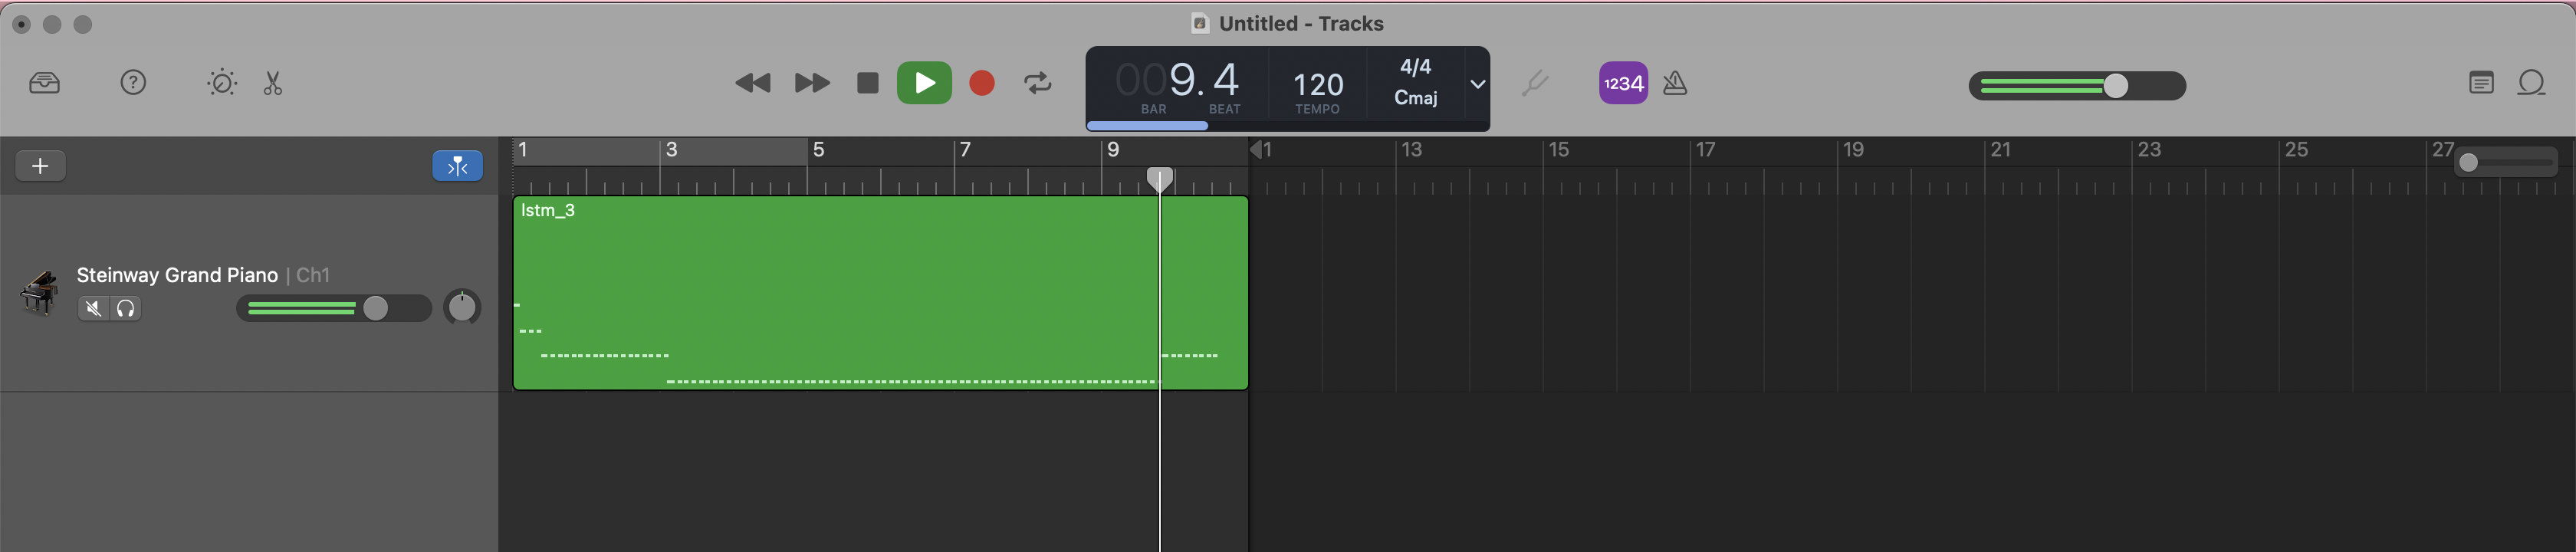

The music generated is undoubtedly not what we wanted. It is always chromatically ascending/descending, so in other words, lacks the agreeable succession or arrangement that defines satisfying music. What we are looking for is the musically satisfying sequences of collective notes. 

To upgrade our model, we think of introducing embedding, creating a LSTM with embedding. 

Since the model takes approximately 10 hours to train on 100 epochs, we train and then save the model to prevent wasting time training multiple times. We call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows us to export a model so it can be used without access to the original Python code*. We save the model in the h5 format. 

Here, we load the model from the saved file using tf.keras.models.load_model(). We can see a summary of the model. 

In [ ]:
!pip install pyyaml h5py

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
embed_model = tf.keras.models.load_model('/content/drive/MyDrive/final/embed_lstm.h5')

# Show the model architecture
embed_model.summary()

Evaluate the model with train_notes, train_durations, target_notes, and target_durations. The final loss we obtain looks very big at first glance, but we just want to focus on the note_loss, which is 3.133, much less than the loss we get from the above basic model. 

We now proceed to listen to what we generate this time!

In [ ]:
n_notes = 128
embed_size = 60
notes_in = tf.keras.layers.Input(shape = (60,))
durations_in = tf.keras.layers.Input(shape = (60,1))

notes_embed = tf.keras.layers.Embedding(n_notes, embed_size, trainable = True)(notes_in)

concat_model = tf.keras.layers.Concatenate()([notes_embed,durations_in])
concat_model = tf.keras.layers.Dropout(0.3)(concat_model)
concat_model = tf.keras.layers.LSTM(512, return_sequences=False)(concat_model)

notes_out = tf.keras.layers.Dense(n_notes, activation = 'softmax', name = 'note')(concat_model)
durations_out = tf.keras.layers.Dense(1, activation = 'relu', name = 'duration')(concat_model)

# embed_model = tf.keras.models.Model([notes_in, durations_in], [notes_out, durations_out])
# embed_model.compile(loss=['sparse_categorical_crossentropy', 
#                     'mse'], optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
train_notes = data[:, :, 1]
train_durations = data[:, :, 0]
target_notes = labels[:, 1]
target_durations = labels[:, 0]

# embed_model.fit([train_notes, train_durations], 
#                     [target_notes, target_durations]
#                     , epochs=100, batch_size=256, validation_split=0.2
#                   )

In [ ]:
embed_model.evaluate([train_notes, train_durations], 
                    [target_notes, target_durations]
                    , batch_size=256
                  )

Same as above, we convert the output of the model back to a midi file that we can listen to. Some adjustments are made to be compatible with the embed version of LSTM. 

In [ ]:
for i in range(10):
    start = np.random.randint(0, len(data)-1)
    pattern_notes = data[start, :, 1]
    pattern_durations = data[start, :, 0]
    prediction_output = []
    
    for item in data[start, :, :]:
        prediction_output.append(item)
    
    for note_index in range(100):
        pattern_notes = np.reshape(pattern_notes, (1, len(pattern_notes), 1))
        pattern_durations = np.reshape(pattern_durations, (1, len(pattern_durations), 1))

        prediction = embed_model.predict([pattern_notes, pattern_durations], verbose=0)
        index = np.random.choice(n_notes, p=prediction[0][0])
        duration = prediction[1][0][0]

        prediction_output.append([index, int(duration)])

        pattern_notes = np.append(pattern_notes, index)
        pattern_notes = pattern_notes[1:len(pattern_notes)]

        pattern_durations = np.append(pattern_durations, duration)
        pattern_durations = pattern_durations[1:len(pattern_durations)]
    notes = pd.DataFrame(prediction_output, columns=['note', 'time'])
    notes['pause'] = 180
    notes['velocity'] = 80
    notes_dict = notes.to_dict('records')
    prep.tune_to_midi(notes_dict, midi_name='embed_lstm_' + str(i))

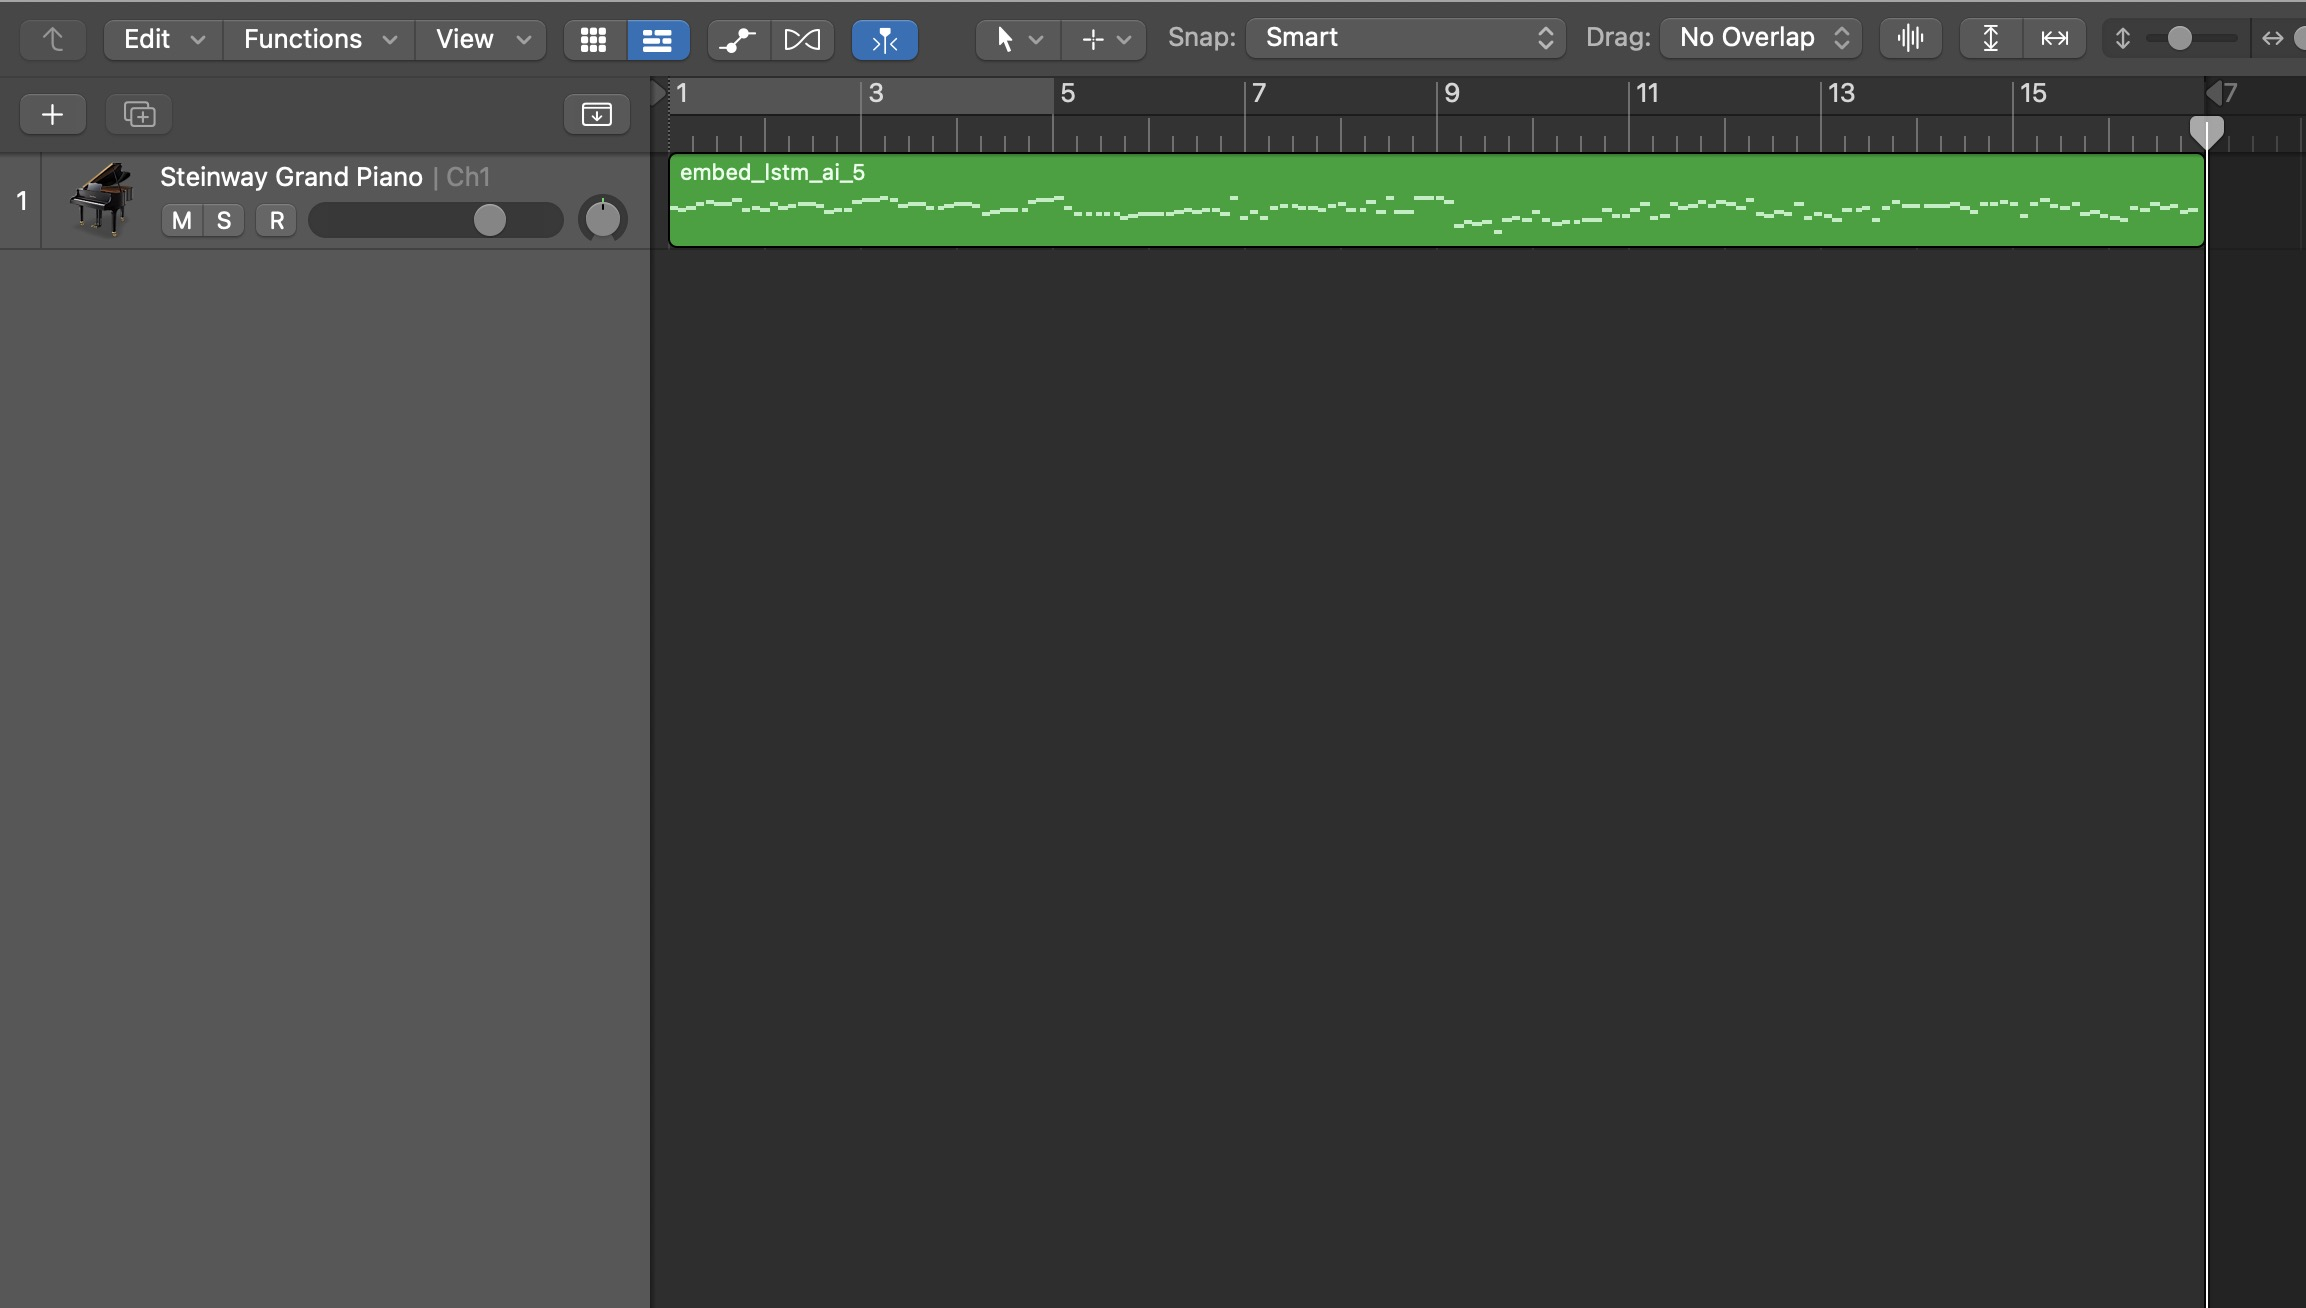

This time, the music we produced has made a great improvement!

We can see that the model do produce a melody, although not perfectly the harmonized music we desired. Our goal is to let the music produced more musically pleasing. 
However, we need more improvement. We found out that the music generated often deviates from the tonal center, it goes off the key. Therefore we think generating model without the disruption of any unnecessary information, with just the note, its relationship to tonal center, and duration, would be easier to handle and output better result. Therefore we created a simplistic dataset based on the labeled notes and its features, to put into a LSTM. 

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import tensorflow as tf 
from statistics import mode

class SimpleDataClass:
    """
    Class to load, parse, preprocess, and encode data
    """
    def __init__(self, meta_filename, filepath) -> None:
        """
        Constructor method to prepare data.

        params:
        meta_filename is the file name of the file containg metadata
        filepath is the path of the folder that contains all the data(labels)
        use_* indicates whether to use those meta features as the data feature 
        """
        #load meta-data
        meta_data = pd.read_csv(meta_filename)

        #load music
        music_data = self.load_music_data(filepath)

        #merge two data
        all_data = meta_data.merge(music_data, on = 'id')
        all_data = all_data.drop(['source', 'transcriber', 'catalog_name', 'composer'], axis=1)

        all_data['note_value'], self.note_value_ref = self.one_hot_encoding(all_data['note_value'])

        #specific parameters
        all_data['key'] = self.find_keys(all_data)
        all_data['note_degree'] = self.calculate_degree(all_data['note'], self.find_keys(all_data))
        all_data['note'] = self.modulate(all_data['note'], all_data['key'])
        all_data = all_data.sort_values(['start_time', 'end_time'])
        all_data.drop(['seconds', 'composition', 'ensemble', 'start_time', 'end_time', 'instrument', 'note', 'start_beat', 'end_beat'], axis = 1)
        self.data = all_data

    def modulate(self, notes, keys):
        """
        modulate all the notes to the same key(C major)
        """
        modulated_notes = []
        for i in range(len(notes)):
            modulated_notes.append(notes[i] - keys[i])
        return np.array(modulated_notes)
    def encode_nn_ready(self):
        """
        make the pandas data frame a tensor to be passed into the neural network
        """
        X = []
        for index, data in self.data.iterrows():
            cur = []
            cur.append(data['seconds'])
            cur.append(data['start_time'])
            cur.append(data['end_time'])
            cur.append(data['instrument'])
            cur.append(data['note'])
            cur.append(data['start_beat'])
            cur.append(data['end_beat'])
            cur.extend(data['note_value'])
            if self.use_movement:
                cur.extend(data['movement'])
            if self.use_ensemble:
                cur.extend(data['ensemble'])
            if self.use_key:
                cur.append(data['note_degree'])
            X.append(np.array(cur, dtype='float32'))

        return np.array(X, dtype='float32')
    def decode_to_datafrom(self, data):
        df = []
        for d in data: 
            cur = {}
            ind = 0
            cur['seconds'] = int(d[ind])
            ind += 1
            cur['start_time'] = int(d[ind])
            ind += 1
            cur['end_time'] = int(d[ind])
            ind += 1
            cur['instrument'] = int(d[ind])
            ind += 1
            cur['note'] = int(d[ind])
            ind += 1
            cur['start_beat'] = d[ind]
            ind += 1
            cur['end_beat'] = d[ind]
            ind += 1
            if self.use_movement:
                cur['movement'] = self.movement_ref[np.argmax(d[ind:ind + len(self.movement_ref)])]
                ind += len(self.movement_ref)
            if self.use_ensemble:
                cur['ensemble'] = self.ensemble_ref[np.argmax(d[ind:ind + len(self.ensemble_ref)])]
                ind += len(self.ensemble_ref)
            df.append(cur)
        return pd.DataFrame.from_records(df)

    def load_music_data(self, filepath):
        """
        load the music data from files
        filepath should be the path of the folder containing all metadata and label data
        """
        all_filenames = glob.glob(filepath + "/*.csv")
        music_data = []
        for filename in all_filenames:
            temp = pd.read_csv(filename)
            temp['id'] = os.path.basename(filename[:-4])
            music_data.append(temp)
        music_data = pd.concat(music_data, axis=0, ignore_index=True)
        music_data['id'] = music_data['id'].astype(str).astype(int)

        return music_data

    def one_hot_encoding(self, array):
        """
        one hot encode categorical feature

        params: an 1-d array of categorical data

        return: a 2-d array of one hot encoded given data, and a dictionary to 
        transform generated feature back into one of the categories.
        """
        value_dict = {value : index for index, value in enumerate(np.unique(array))}
        ref_dict = {index : value for index, value in enumerate(np.unique(array))}
        array_trans = [value_dict[value] for value in array]
        ohe = tf.one_hot(array_trans, len(value_dict))
        return list(ohe), ref_dict

    def calculate_degree(self, notes, keys):
        """
        calculate the tonal degree of each term

        params: a 1-d array of notes and a 1-d of keys of the piece where the note
        came from. They should have the same length

        return: array of note degree
        """
        re = []
        for (n, k) in zip(notes, keys):
            diff = n % 12 - k
            diff = diff + 12 if diff < 0 else diff
            re.append(diff)
        return np.array(re)
    def find_keys(self, all_data):
        """
        find the key each note is in. If the composition specifies the key, use 
        it, otherwise we assume the most common note in the peice to be the key.

        params: data frome of the complete data

        return: array of keys of each input note
        """
        self.ref = {'C':0, 'C-sharp':1, 'D-flat':1, 'D':2, 'D-sharp':3, 'E-flat':3, 'E':4, \
            'F':5, 'F-sharp':6, 'G-flat':6, 'G':7, 'G-sharp':8, 'A-flat':8, 'A':9, 
            'A-sharp':10, 'B-flat':10, 'B':11}

        data = np.array(all_data['composition'])
        unresolved = []

        for i, d in enumerate(data):
            if d.split()[-2] in self.ref:
                data[i] = self.ref[d.split()[-2]]
            else:
                if d not in unresolved:
                    unresolved.append(d)
        unresolved_dict = {}
        
        for composition in unresolved:
            notes_in_piece = all_data[all_data['composition'] == composition]['note']
            notes_in_piece = np.array(notes_in_piece) % 12
            #we assume the key is the most common note in the piece
            unresolved_dict[composition] = mode(notes_in_piece)
        for i, d in enumerate(data):
            if d in unresolved_dict:
                data[i] = unresolved_dict[d]
        
        return np.array(data)


In [ ]:
simple_data_class = SimpleDataClass('/content/drive/MyDrive/final/archive/musicnet_metadata.csv',
                    '/content/drive/MyDrive/final/archive/musicnet/musicnet/test_labels')
data = np.array(simple_data_class.data)[:, 13]

The model has similiar structure with the embedded LSTM model we had earlier, a embedding_layer, a dense layer, a dropout layer, a LSTM layer and another dense layer.
We can see that most of the notes is in the key. The result sound much better. But towards the end we tends to have a trivial solution. Our model, in its essence, is still probabilistic and the output's probability is randomly distributed and that is why we have different notes. Overall the performance is not ideal.

In [ ]:
n_notes = 12
embed_size = 200
notes_in = tf.keras.layers.Input(shape = (200,))

embedding_layer = tf.keras.layers.Embedding(n_notes, embed_size, trainable = True)
dense = tf.keras.layers.Dense(200, activation = 'softmax')
dropout = tf.keras.layers.Dropout(0.6)
lstm = tf.keras.layers.LSTM(256, return_sequences=False)
out_layer = notes_out = tf.keras.layers.Dense(n_notes, activation = 'softmax', name = 'note')



degree_model = tf.keras.models.Sequential([
  embedding_layer,
  dense,
  dropout,
  lstm,
  out_layer
])
degree_model.summary()
degree_model.compile(loss = 'sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = 'accuracy')
degree_model.fit(x, y, epochs=30, batch_size=64, validation_split=0.2)

In [ ]:
degree_model.summary()

In [ ]:
generate_tune(x, degree_model,'degree_embed_lstm_',  n_notes=12, degree=True)

We can see that by simplifying our dataset, the model grants us better result. Music itself is still too complicated for the model we proposed, therefore by adding embedding, preprocessing, getting rid of all the non-necessary information that induce variation in the data, we simplified the task from generating a peice of music with appropriate style, sequence of notes, with the right instrument etc. to just generate a meaningful line of melody. The experiemnt show that music generation is not an easy task that involves not only logical deduction, which recurrent networks are good at learning, but also a divergent way of thinking, it's a creative task. Deep learning's probabilistic nature is still weak on this. Therefore we couldn't have a satisfying result.

As a new way for improving the music, we think of also implementing a 1D convolve layer and LSTM with degree.

Our motivation is that the hyopthesis that convolving on music will enlarge the view of lstm.

For the result, it is better than plain lstm with embedding (which has trivial outputs), but has the problem of overfitting during training, and it's hard to cope with (overfitting with training accuracy .7, validation accuracy 0.12). 

In [ ]:
n_notes = 12
embed_size = 20
notes_in = tf.keras.layers.Input(shape = (200,))

embedding_layer = tf.keras.layers.Embedding(n_notes, embed_size, trainable = True)
conv = tf.keras.layers.Conv1D(16, (3), strides = 2, activation = 'relu')
pooling = tf.keras.layers.MaxPooling1D(2, strides = 1)
lstm = tf.keras.layers.LSTM(64, return_sequences=False)
out_layer = notes_out = tf.keras.layers.Dense(n_notes, activation = 'softmax', name = 'note')



cnn_lstm_model = tf.keras.models.Sequential([
  embedding_layer,
  conv,
  pooling,
  lstm,
  out_layer
])
cnn_lstm_model.summary()
cnn_lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = 'accuracy')
cnn_lstm_model.fit(x, y, epochs=50, batch_size=64, validation_split=0.2)

The below is another try, using the BiLSTM with degrees. 

The motivation is that to allow the LSTM’s to learn faster in parallel and share the parameters among each other.

The result we get is in fact, the best of the three models, which does not has the problem of overfitting. 

In [ ]:
n_notes = 12
embed_size = 32
input_layer = tf.keras.layers.Input(shape = (200,))
notes_embed = tf.keras.layers.Embedding(n_notes, embed_size, trainable = True)(input_layer)
dense_layer = tf.keras.layers.Dense(50, activation = 'softmax', name = 'dense_layer')(notes_embed)
dropout_layer = tf.keras.layers.Dropout(0.7, name = 'dropout')(dense_layer)
lstm1 = tf.keras.layers.LSTM(64, return_sequences=False, name = 'lstm1')(dropout_layer)
lstm2 = tf.keras.layers.LSTM(64, return_sequences=False, name = 'lstm2')(dropout_layer)
out_layer = tf.keras.layers.Dense(n_notes, activation = 'softmax', name = 'output_layer') (tf.add(lstm1,lstm2))



bilstm_model = tf.keras.models.Model(input_layer, out_layer)
bilstm_model.summary()
bilstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = 'accuracy')
bilstm_model.fit(x, y, epochs=50, batch_size=64, validation_split=0.2)

In [ ]:
generate_tune(x, bilstm_model,'degree_bilstm_',  n_notes=12, degree=True)

# Conclusion


---
Music, by its sequential nature, is very similiar to natural languages. It contains less tokens(there are less notes than vocabularies in English), but it's also more explicit so that it's harder to capture the essence of a "good" tone. Music also has more complexity and diversity than sentence. A note that sound awful in one piece can be hypnotic in another. Therefore we can say it's harder for computers to learn how to write music than to write sentence. 

Our attempt on this task via various deep-learning algorithms shows that the artificial intelligence is far from human beings in terms of creativity in music. The tone we produced, although contains short parts that has tonal quality, can hardly be regarded as music. Those genrated pieces contains too much jumps that are abrupt and dissonent, and lack a recognizable motif or any pattern that is common in real music. 

We suspect that our data, made of classical pieces, are too complex for computers. The next step on music generation would be to collect new dataset that are easier for deep-learning model to undersand. Pop songs with simple, repeated chord progressions and melody line, or analysed and simplified classical piece with all the embellishing tones deleted are probably better data to begin with. We also will adjust our model to think vertically, learning from the relationship between different parts of a piece, learning from chords that are made of different notes played independently but at the same time.

While cmputer had a hard time generating even a simply line of melody, human composers can easily write beatiful piece, harmony that conveys certain emotion. Creativity is definitely not as simple as a logical task, emotion plays a huge part in it. Music, or any sort of art, created by human are not definite or determinent like in deep learning models that are based on computation of input data, it has individuality, it has soul. Based on our experiment results, we still rest assurd that human minds are uncomparable with deep-learning models. However, we cannot help ouselves imagine maybe one day, computers can generate music as beautiful, as emotional, or even more so, then human composers. Then who are we, what are we? Furthering study on music generation grants us insights on the philosophical nature of creativity, it might unveil a brand new understanding of our culture, therefore it's a subject deserves further exploration.

# References

Won Minz, Choi Keunwoo, Serra Xavier. “SEMI-SUPERVISED MUSIC TAGGING TRANSFORMER”. Music Technology Group, Universitat Pompeu Fabra, Barcelona, Spain. ByteDance, Mountain View, California, United States. 26 November 2021. 

Kalingeri Vasanth, Grandhe Srikanth. “Music Generation Using Deep Learning”. University of Massachusetts Amherst, Amherst, Massachusetts. 15 December 2016. 

Briot Jean-Pierre, Pachet François. ”Music Generation by Deep Learning – Challenges and Directions”. Sorbonne Universités, UPMC Univ Paris 06, CNRS, LIP6, Paris, France. Spotify Creator Technology Research Lab, Paris, France. 30 September 2018. 

Briot Jean-Pierre, Hadjeres Gaëtan, Pachet François-David. “Deep Learning Techniques for Music Generation – A Survey”. Sorbonne Université, CNRS, LIP6, F-75005 Paris, France. Sony Computer Science Laboratories, CSL-Paris, F-75005 Paris, France. Spotify Creator Technology Research Lab, CTRL, F-75008 Paris, France.

RIS_IRIS. "Audio Generation Using Neural Net". kaggle. https://www.kaggle.com/code/risiris/audio-generation-using-neural-net

SMOGOMES. "Music generation based on classics". kaggle. https://www.kaggle.com/code/smogomes/music-generation-based-on-classics#2.-Data-analysis-%F0%9F%93%8A
